# **8a.nu Climbing Data Analysis & Predictions**

This notebook presents an exploratory data analysis of a sport climbing dataset obtained from Kaggle. The dataset (https://www.kaggle.com/datasets/jordizar/climb-dataset/data) includes public logged data scraped from popular climbing website 8a.nu. 

In this notebook, a number of questions are posed and answered through analysis and visualisation. Pandas and numpy are used to process the data and visualisations are created using matplotlib and seaborn. At the end of the notebook is a bonus section which compares two common machine learning models to see if we can predict max climbing grade. The scikit-learn package is utilised for this.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Exploring the dataset

In [2]:
# Import and load data
climber_data = pd.read_csv('climbing_dataset/climber_df.csv')
grade_data = pd.read_csv('climbing_dataset/grades_conversion_table.csv')

Inspecting the climber dataset.

In [3]:
# Display data head
climber_data.head()

,user_id,country,sex,height,weight,age,years_cl,date_first,date_last,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
0,1,SWE,0,177,73,41.0,21,1999-02-06 23:00:00,2001-07-31 22:00:00,84,36,55,62,46.750000,1999,2001
1,3,SWE,0,180,78,44.0,22,1999-03-31 22:00:00,2000-07-19 22:00:00,12,53,51,59,52.833333,1999,2000
2,4,SWE,1,165,58,33.0,16,2004-06-30 22:00:00,2009-05-26 22:00:00,119,53,49,64,53.890756,2004,2009
3,10,SWE,0,167,63,52.0,25,2000-01-14 23:00:00,2017-06-01 22:00:00,298,53,49,63,49.406040,2000,2017
4,16,NOR,0,177,68,44.0,21,1998-02-27 23:00:00,2010-05-13 22:00:00,5,53,49,53,51.400000,1998,2010


From the author is a description of the variables in the climber dataset:
- **date_first** -> Date of the first logged ascent
- **date_last** -> Date of the last logged ascent
- **grades_first** -> Grade of the first logged ascent
- **grades_last** -> Grade of the last logged ascent
- **years_cl** -> Number of years climbing
- **grades_count** -> Number of routes logged
- **year_first** -> Year of the first logged ascent
- **year_last** -> Year of the last logged ascent

Display summary statistics to two decimal places.

In [4]:
climber_data.describe().map(lambda x: f'{x:0.2f}')

,user_id,sex,height,weight,age,years_cl,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
count,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00,10927.00
mean,29411.10,0.13,176.15,67.61,33.33,12.67,79.79,45.65,46.98,53.76,45.51,2008.62,2012.31
std,18022.13,0.33,8.51,9.68,7.59,6.11,141.41,9.48,9.42,9.68,7.89,28.83,4.16
min,1.00,0.00,137.00,40.00,12.00,1.00,1.00,28.00,28.00,29.00,28.50,0.00,1991.00
25%,14651.00,0.00,171.00,63.00,28.00,8.00,8.00,38.00,40.00,46.00,39.40,2006.00,2009.00
50%,27323.00,0.00,177.00,68.00,33.00,12.00,28.00,46.00,48.00,55.00,45.15,2009.00,2013.00
75%,43240.50,0.00,182.00,73.00,38.00,17.00,90.00,53.00,53.00,62.00,51.21,2012.00,2016.00
max,67020.00,1.00,202.00,93.00,69.00,29.00,2445.00,75.00,77.00,77.00,75.27,2017.00,2017.00


This provides us with some interesting general user information such as average height, weight, age, and years spent spent climbing. In addition, we can see grade related information such as average max grade. At the moment, the max grade is meaningless as it is in the format of grade id.

Lets now look at the grade conversion table to make sense of this.

In [5]:
grade_data.head(-5)

,Unnamed: 0,grade_id,grade_fra
0,0,0,-
1,1,1,-
2,2,2,-
3,3,3,1
4,4,4,1a
...,...,...,...
75,75,75,9a+
76,76,76,9a+/9b
77,77,77,9b
78,78,78,9b/+


Each grade id corresponds to a french grade.

**What is the average max grade climbed in the dataset?**

In [6]:
print(f'Average max french grade: {grade_data.iloc[54]["grade_fra"]}')

Average max french grade: 7b/+


Now that we know what the data looks like, lets plot some of the variables to identify any relationships.
Here are some questions:

- What is the proportion of male and female on 8a.nu?
- Which countries have the most experienced climbers?
- Is there a relationship between weight and average grade logged? And is it similar across gender?
- Is there a positive correlation between number of years climbed and average grade logged?
- Does the number of routes logged correlate to max grade?

## Cleaning the data

First lets clean the data to remove columns we're not interested in.

In [7]:
# Remove user_id, date_first, date_last, grades_first, grades_last, year_first and year_last
climber_data.drop(labels=['user_id', 'date_first', 'date_last', 'grades_first', 'grades_last',
                         'year_first', 'year_last'], axis=1, inplace=True)

# Display climber dataframe
climber_data.head()

,country,sex,height,weight,age,years_cl,grades_count,grades_max,grades_mean
0,SWE,0,177,73,41.0,21,84,62,46.750000
1,SWE,0,180,78,44.0,22,12,59,52.833333
2,SWE,1,165,58,33.0,16,119,64,53.890756
3,SWE,0,167,63,52.0,25,298,63,49.406040
4,NOR,0,177,68,44.0,21,5,53,51.400000


Lets round the mean grade to the nearest integer so we can map it to the french grade, and convert the data types to sensible values.

In [8]:
# Round mean grade to nearest integer
climber_data = climber_data.round().convert_dtypes()
display(climber_data.head())
display(climber_data.dtypes)

,country,sex,height,weight,age,years_cl,grades_count,grades_max,grades_mean
0,SWE,0,177,73,41,21,84,62,47
1,SWE,0,180,78,44,22,12,59,53
2,SWE,1,165,58,33,16,119,64,54
3,SWE,0,167,63,52,25,298,63,49
4,NOR,0,177,68,44,21,5,53,51


country         string[python]
sex                      Int64
height                   Int64
weight                   Int64
age                      Int64
years_cl                 Int64
grades_count             Int64
grades_max               Int64
grades_mean              Int64
dtype: object

Lets rename *grades_count* to *routes_count* to make it clearer.

In [9]:
climber_data.rename(columns={"grades_count": "routes_count"}, inplace=True)
climber_data.head()

,country,sex,height,weight,age,years_cl,routes_count,grades_max,grades_mean
0,SWE,0,177,73,41,21,84,62,47
1,SWE,0,180,78,44,22,12,59,53
2,SWE,1,165,58,33,16,119,64,54
3,SWE,0,167,63,52,25,298,63,49
4,NOR,0,177,68,44,21,5,53,51


Lets create two columns containing the max and mean french grades for each entry.

In [10]:
climber_data['french_max'] = climber_data['grades_max'].map(grade_data['grade_fra'])
climber_data['french_mean'] = climber_data['grades_mean'].map(grade_data['grade_fra'])
climber_data.head()

,country,sex,height,weight,age,years_cl,routes_count,grades_max,grades_mean,french_max,french_mean
0,SWE,0,177,73,41,21,84,62,47,8a/+,6c+
1,SWE,0,180,78,44,22,12,59,53,7c+,7b
2,SWE,1,165,58,33,16,119,64,54,8a+/8b,7b/+
3,SWE,0,167,63,52,25,298,63,49,8a+,7a
4,NOR,0,177,68,44,21,5,53,51,7b,7a+


Finally, lets check for any missing values.

In [11]:
display(climber_data.isna().any())

country         False
sex             False
height          False
weight          False
age             False
years_cl        False
routes_count    False
grades_max      False
grades_mean     False
french_max      False
french_mean     False
dtype: bool

There are no missing values.

## Visualising the data

Set global figure settings

In [12]:
sns.set_theme(rc={"figure.dpi": 96, "axes.titlesize":14})
sns.set_palette('Set2')

**How many male and female contributors are there to 8a.nu?**

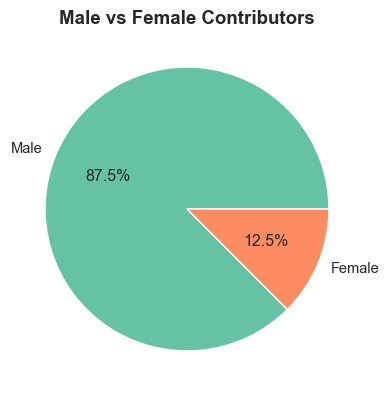

In [13]:
# Get values male and female values
male_count = climber_data[climber_data['sex'] == 0]['sex'].count()
female_count = climber_data[climber_data['sex'] == 1]['sex'].count()
pie_labels = ['Male', 'Female']

# Plotting data on pie chart
fig, ax = plt.subplots()
ax.pie([male_count, female_count], labels=pie_labels, autopct='%1.1f%%')
ax.set_title('Male vs Female Contributors', weight='bold')
plt.show()

The majority of users who use 8a.nu to log climbs are male.

**Which countries have the most experienced climbers?**

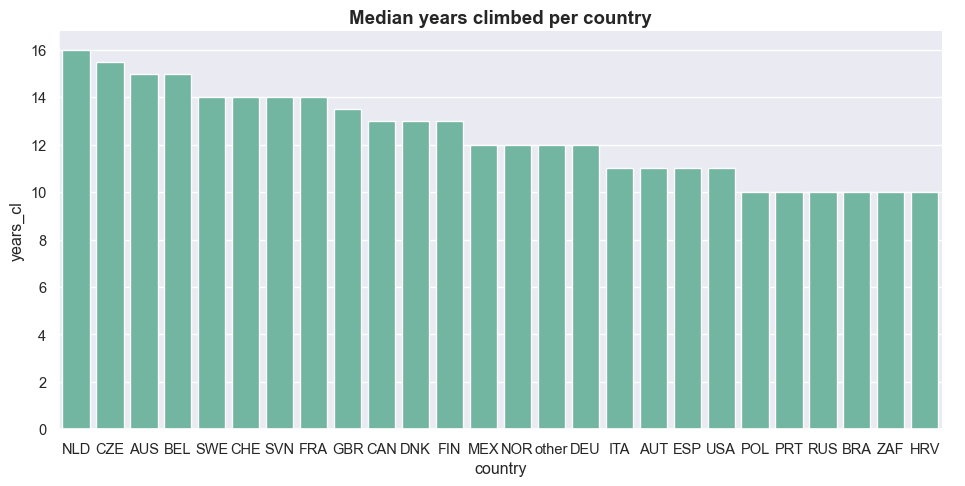

In [14]:
# Create bar chart
sns.catplot(data=climber_data, x='country', y='years_cl', kind='bar',estimator='median', errorbar=None, aspect=2, 
            order=climber_data.groupby(['country'])['years_cl'].median().sort_values(ascending=False).index)
plt.title('Median years climbed per country', weight='bold')
plt.show()

The netherlands has the most experienced contributors and croatia has the least experienced. This is not that insightful as it is likely just indicitive of the age distribution of climbers on 8a.nu for each country.

**Is there a relationship between weight and average grade logged? And is it similar across gender?**

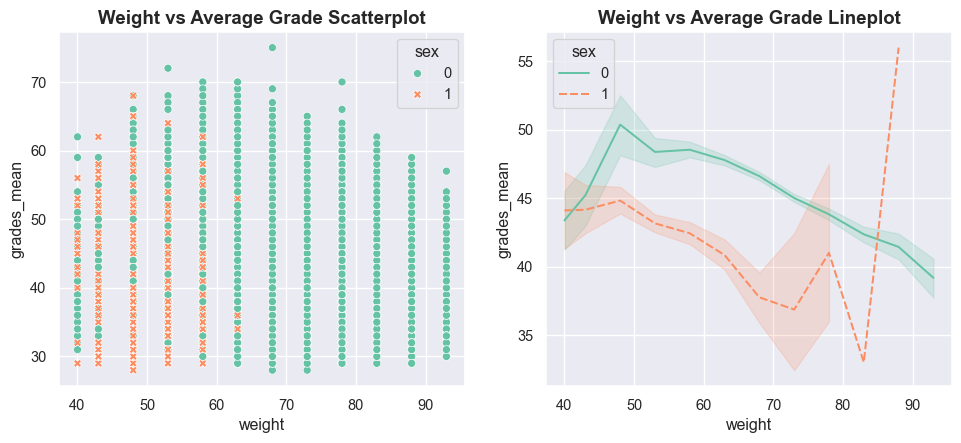

In [15]:
# Create plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12, 4.8])
#fig.figsize = [10.0, 4.8]
sns.scatterplot(data=climber_data, x='weight', y='grades_mean', hue='sex', style='sex', ax=ax1)
sns.lineplot(data=climber_data, x='weight', y='grades_mean', hue='sex', style='sex', ax=ax2)
ax1.set_title('Weight vs Average Grade Scatterplot', weight='bold')
ax2.set_title('Weight vs Average Grade Lineplot', weight='bold')
plt.show()

The plot on the left highlights that weight is not continuous and is discrete. The plot on the right, which aggregates over repeated x values, displays the mean and 95% confidence interval. This shows that average grade logged tends to decrease with increasing weight for both genders. The data may be better represented as a boxplot...

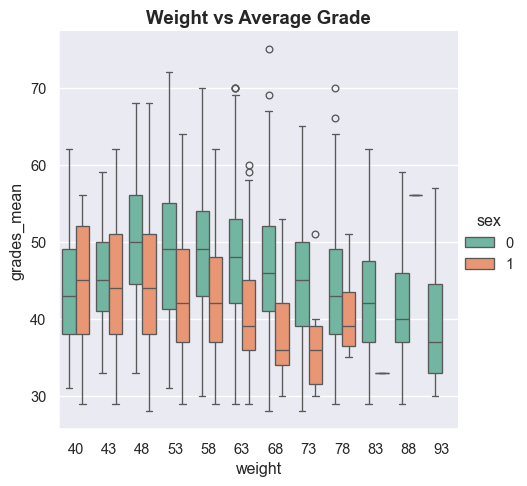

In [16]:
# Create boxplot
sns.catplot(data=climber_data, x='weight', y='grades_mean', hue='sex', kind='box')
plt.title('Weight vs Average Grade', weight='bold')
plt.show()

This presentation provides a better view of the data variance for each weight interval, yet still shows the trend of average grade decreasing with increasing weight.

**Is there a positive correlation between number of years climbed and average grade logged?**

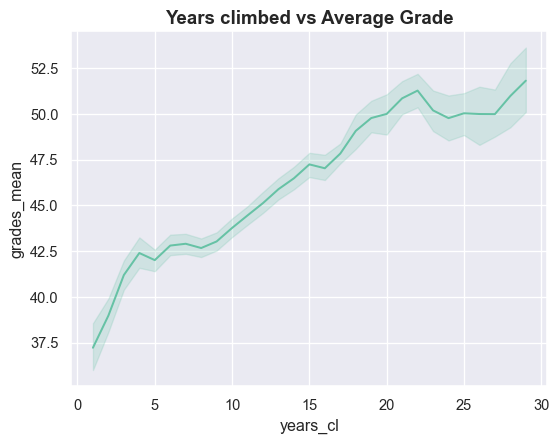

In [17]:
# Plot number of years climbed against average grade
sns.lineplot(data=climber_data, x='years_cl', y='grades_mean')
plt.title('Years climbed vs Average Grade', weight='bold')
plt.show()

Expectedly, there is a positive relationship between number of years climbed and average grade logged.

**Does the number of routes logged correlate to max grade?**

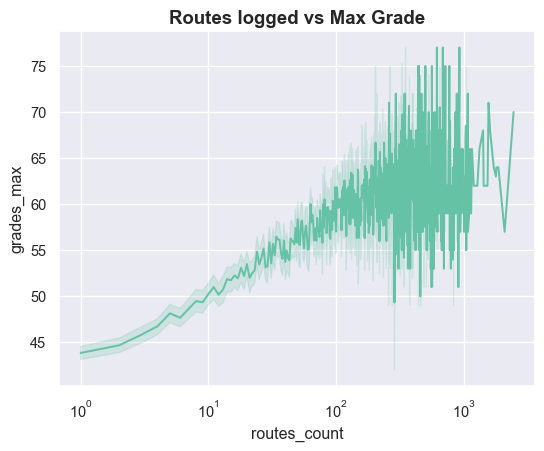

In [18]:
# Plot number of routes logged versus max grade
sns.lineplot(data=climber_data, x='routes_count', y='grades_max')
plt.xscale('log')
plt.title('Routes logged vs Max Grade', weight='bold')
plt.show()

There is also a positive relationship between the number of routes logged and the max grade climbed, with greater uncertainty at the higher route counts.

## Bonus: Can we predict max grade based on the features provided? - Comparing simple regression and classification models ##

We've seen that there are a number of variables/features which influence route climbing grade. Now we want to use these features in a model to see if we can predict max route grade.

First we need to decide what model we want to use for this problem. The target is a discrete numeric variable, so ordinarily a classification model would be appropriate. However, we have to consider that it is also a scale where the ordering of values is important. Ideally, an ordinal regression model should be used. However sci-kit learn does not have an inbuilt ordinal regression model, so we will start by trying a simple linear regression model.

### Data Preprocessing

Lets have a look at the data to see if we can remove any outliers.

In [19]:
display(climber_data.describe())

,sex,height,weight,age,years_cl,routes_count,grades_max,grades_mean
count,10927.0,10927.0,10927.0,10927.0,10927.0,10927.0,10927.0,10927.0
mean,0.125103,176.152009,67.608676,33.333852,12.672188,79.794546,53.764437,45.506086
std,0.330851,8.508669,9.677316,7.590989,6.108451,141.411297,9.679533,7.898388
min,0.0,137.0,40.0,12.0,1.0,1.0,29.0,28.0
25%,0.0,171.0,63.0,28.0,8.0,8.0,46.0,39.0
50%,0.0,177.0,68.0,33.0,12.0,28.0,55.0,45.0
75%,0.0,182.0,73.0,38.0,17.0,90.0,62.0,51.0
max,1.0,202.0,93.0,69.0,29.0,2445.0,77.0,75.0


The standard deviation of routes_count is very large, and the distribution of the data is likely right skewed. The outliers at the top of the range are heavily influencing the mean score.

In [20]:
# Columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'routes_count']

# Calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(climber_data[cols_to_consider].astype('float')))

# Identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)

# Remove outliers
climber_data_clean = climber_data[non_outlier_mask]

# Descriptive statistics after outlier removal to confirm outliers have been removed
climber_data_clean.describe()

,sex,height,weight,age,years_cl,routes_count,grades_max,grades_mean
count,10603.0,10603.0,10603.0,10603.0,10603.0,10603.0,10603.0,10603.0
mean,0.123267,176.38225,67.78242,33.373762,12.637461,64.755258,53.570216,45.479298
std,0.328759,8.105335,9.485138,7.488517,6.105502,89.850251,9.646958,7.928992
min,0.0,151.0,40.0,12.0,1.0,1.0,29.0,28.0
25%,0.0,171.0,63.0,28.0,8.0,7.0,46.0,39.0
50%,0.0,177.0,68.0,33.0,12.0,27.0,55.0,45.0
75%,0.0,182.0,73.0,38.0,17.0,83.0,62.0,51.0
max,1.0,200.0,93.0,69.0,29.0,501.0,77.0,75.0


### Creating and evaluating the linear regression model

In [21]:
# Define features and target
features = climber_data_clean[['sex', 'height', 'weight', 'age', 'years_cl', 'routes_count']]
target = climber_data_clean['grades_max']

In [22]:
# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [23]:
# Define scaler
scaler = StandardScaler()

# Scale the training data
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

In [24]:
# Create model
linreg_model = LinearRegression()

# Fit model to scaled training data
linreg_model.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
# Display feature names
print(f'Number of features in model: {linreg_model.n_features_in_}')
print(f'Estimated feature coefficients: {linreg_model.coef_}')

Number of features in model: 6
Estimated feature coefficients: [-1.67881732  0.53398546 -2.16036179 -3.00484126  4.2337616   4.02352539]


In [26]:
# Predict target values for test data
linreg_y_predict = linreg_model.predict(X_test_scaled)

In [27]:
# Calculate accuracy, mean absolute error and mean squared error of model
linreg_r2 = r2_score(y_test, linreg_y_predict)
linreg_mae = mean_absolute_error(y_test, linreg_y_predict)
linreg_mse = mean_squared_error(y_test, linreg_y_predict)
print(f'Coefficient of determination: {linreg_r2}')
print(f'Mean Absolute Error: {linreg_mae}')
print(f'Mean Squared Error: {linreg_mse}')

Coefficient of determination: 0.4110035425510309
Mean Absolute Error: 6.01094999079128
Mean Squared Error: 56.00334646606588


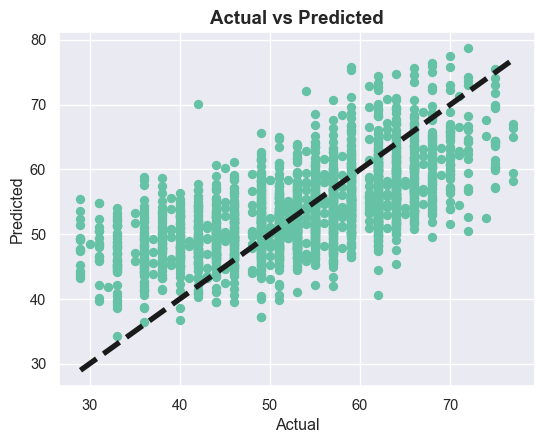

In [37]:
# Plot predicted vs real scores
plt.scatter(y_test, linreg_y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted', weight='bold')
plt.show()

### Creating and evaluating the k nearest neighbors model

In [29]:
# Create model
knn_model = KNeighborsRegressor()

# Fit model to scaled training data
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [30]:
# Display feature names
print(f'Number of features in model: {knn_model.n_features_in_}')

Number of features in model: 6


In [31]:
# Display accuracy score of model
knn_model.score(X_test_scaled, y_test)

0.39089053084893166

In [32]:
# Predict target values for test data
knn_y_predict = knn_model.predict(X_test_scaled)

In [33]:
# Calculate mean absolute error and mean squared error of model
knn_mae = mean_absolute_error(y_test, knn_y_predict)
knn_mse = mean_squared_error(y_test, knn_y_predict)
print(f'Mean Absolute Error: {knn_mae}')
print(f'Mean Squared Error: {knn_mse}')

Mean Absolute Error: 6.063372312334968
Mean Squared Error: 57.91574500188609


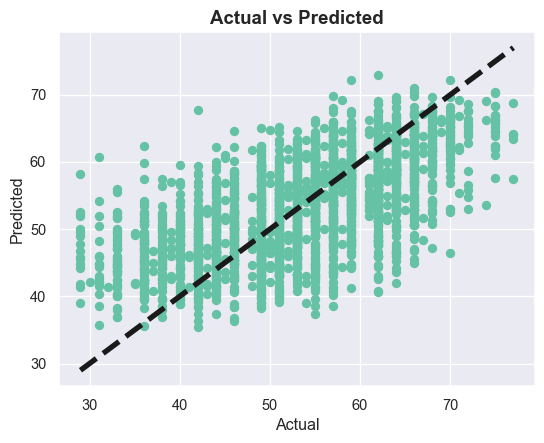

In [38]:
# Plot predicted vs real scores
plt.scatter(y_test, knn_y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted', weight='bold')
plt.show()

To conclude, the performance of both models is poor and likely due to the lack of useful features in the dataset.

Furthermore, if you plot the histogram of max grade, we observe some odd distribution...

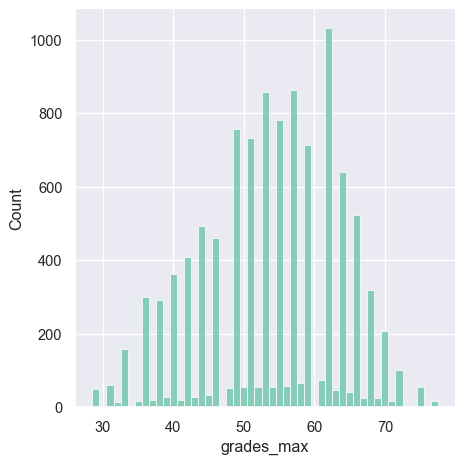

In [35]:
sns.displot(data=climber_data, x='grades_max', discrete=True)
plt.show()

The distribution of the target variable is normally distributed, but you can see the stepped nature within the grade scale. Presumably this corresponds to the 'slash' grades (e.g. 7a/7a+) which are not widely used.

Lets confirm this by counting the entries of each max french grade.

In [36]:
# Count each max french grade
climber_data['french_max'].value_counts()

french_max
8a/+      1032
7c         863
7b         858
7b+        782
7a         758
7a+        732
7c+        713
8a+/8b     639
8b/+       523
6b+/6c     494
6c/+       461
6b/+       410
6a+/6b     362
8b+/8c     318
6          299
6a/+       291
8c/+       207
5b+        159
8c+/9a     102
8a          73
7c/+        65
5a+         60
7b+/7c      59
9a+         56
7a/+        56
7b/+        56
7a+/7b      56
6c+/7a      53
5           49
8a+         46
8b          42
6c          32
6a+         29
6b+         28
8b+         24
8c          24
6b          19
6a          19
5c+         18
9b          16
8c+         16
5b          13
9a/+         7
5a           6
9a+/9b       2
Name: count, dtype: int64